# Sentiment analysis
"Small" subsets Data from 
https://nijianmo.github.io/amazon/index.html (May 1996 - Oct 2018)
https://jmcauley.ucsd.edu/data/amazon_v2/index.html

Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
asin - ID of the product, e.g. 0000013714
reviewerName - name of the reviewer
vote - helpful votes of the review
style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
reviewText - text of the review
overall - rating of the product
summary - summary of the review
unixReviewTime - time of the review (unix time)
reviewTime - time of the review (raw)
image - images that users post after they have received the product

* Metadata

asin - ID of the product, e.g. 0000031852
title - name of the product
feature - bullet-point format features of the product
description - description of the product
price - price in US dollars (at time of crawl)
imageURL - url of the product image
imageURL - url of the high resolution product image
related - related products (also bought, also viewed, bought together, buy after viewing)
salesRank - sales rank information
brand - brand name
categories - list of categories the product belongs to
tech1 - the first technical detail table of the product
tech2 - the second technical detail table of the product
similar - similar product table

In [1]:
# Data manipulation
import pandas as pd
#pd.set_option('max_columns', 200)
import numpy as np
#conda install pyarrow

# Importing
import os
import gzip
import json
#conda install pyyaml
import yaml

# Data visualisation
import matplotlib.pylab as plt
plt.style.use('ggplot')
import seaborn as sns

#pip install textstat
import textstat

config = yaml.safe_load(open('config.yml'))

# Output folder
out_dir = config['in_dir']
raw_dir = config['raw_dir']
# Create the output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    df = {}
    for i, d in enumerate(parse(path)):
        df[i] = d
    return pd.DataFrame.from_dict(df, orient='index')

In [2]:
# 15min to load
raw_df = getDF(os.path.join(raw_dir, 'Appliances.json.gz'))
#raw_df = getDF(os.path.join(raw_dir, 'Electronics_5.json.gz'))
raw_df.head()
#print(df.info())
#df.describe()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN
1,5.0,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN
2,5.0,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,1381363200,NaN
3,5.0,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,{'Format:': ' Hardcover'},Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,1381276800,NaN
4,5.0,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,{'Format:': ' Hardcover'},Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",1378512000,NaN


## Feature understanding
Since reviews is the main variable being evaluated, how are they spread across the dataset?

In [3]:
# How many distinct products in the dataset? 160052
# How many reviews do they have?
summary_df = raw_df['asin'].value_counts()
#top_products = list(summary_df.head(10).index)

summary_df

B000AST3AK    6510
B004UB1O9Q    5702
B0014CN8Y8    4048
B00KJ07SEM    3200
B0045LLC7K    2936
              ... 
B00NSELT0A       1
B00NSEM6XY       1
B00AF7SDT8       1
B00DWGV3G4       1
B00U5U3ANO       1
Name: asin, Length: 30252, dtype: int64

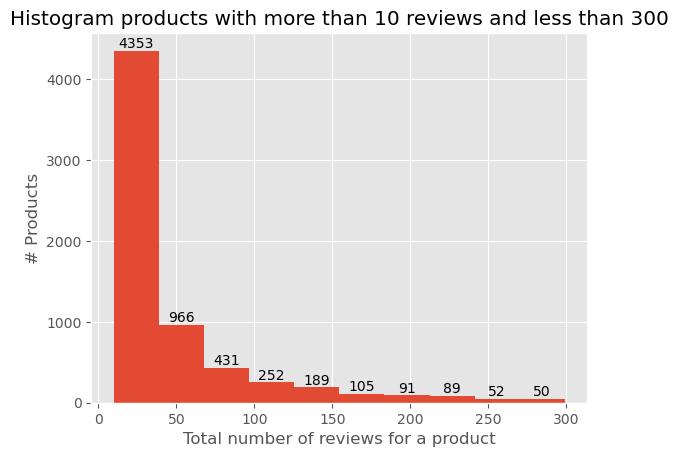

In [4]:
# Excluding outliers
df_ids = summary_df[(summary_df>=10) & (summary_df<=300)]

counts, edges, bars = plt.hist(df_ids)

plt.bar_label(bars)

plt.title("Histogram products with more than 10 reviews and less than 300")
plt.xlabel("Total number of reviews for a product")
plt.ylabel("# Products")

# Alternatively a boxplot
#plt.boxplot(summary_df)
plt.show()

# The absolute majority of product have less than 50 reviews.

## Data Preparation

In [5]:
# Limiting the dataset to the most representative examples
# That is for products that are close to the mean +-threshold
#threshold = config['threshold']
#median_df = summary_df[(summary_df >= summary_df.mean()*(1-threshold)) &
#                  (summary_df <= summary_df.mean()*(1+threshold))]

#df = raw_df[raw_df['asin'].isin(list(median_df.index))]

df = raw_df.query('asin in list(@df_ids.index)')

print(f'Total of {len(df_ids)} products remain')

Total of 6578 products remain


In [6]:
# Checking for missing values
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': round(df.isnull().sum() * 100 / len(df),0)})\
                                 .sort_values('percent_missing', ascending=False)
missing_value_df

,column_name,percent_missing
image,image,99.0
vote,vote,87.0
style,style,86.0
overall,overall,0.0
verified,verified,0.0
reviewTime,reviewTime,0.0
reviewerID,reviewerID,0.0
asin,asin,0.0
reviewerName,reviewerName,0.0
reviewText,reviewText,0.0


In [7]:
# Removing unecessary columns, some due to too many missing values
print(df.columns)

df = df[['asin', 'overall', 'reviewText', 'summary', 'unixReviewTime', 'style', 'vote']]
# Alternative
#df.drop(columns=['verified', 'reviewerID', 'style', 'reviewerName','unixReviewTime', 'vote', 'image'])

# Check for duplicated values
df = df.loc[~df.duplicated(subset=['reviewText', 'asin', 'unixReviewTime'])]

# Only rows which has review text
df = df.dropna(subset=['reviewText'])

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image'],
      dtype='object')


In [8]:
import re

def amazon_date_to_iso(date):
    '''
    From the format '*m *d, yyyy' to 'yyyy-mm-dd'
    '''
    # Month
    m_= re.search(r'\s', date)
    m = date[0:m_.start()]
    if len(m)<2:
        m = '0' + m
    
    # Day
    d_ = re.search(r', ', date)
    d = date[m_.end():d_.start()]
    if len(d)<2:
        d = '0' + d

    # Year
    y = date[d_.end():]
    if len(y)<4:
        y = '20' + y
    return y+'-'+m+'-'+d

In [9]:
# Changing data types for memory usage efficiency
#https://pandas.pydata.org/docs/user_guide/basics.html#basics-dtypes

# Max value of votes
#print(product_df['vote'].dropna().astype('Int32', errors='ignore').max())

df = df.astype({'asin': 'string',
                'overall': 'category',
                'reviewText': 'string',
                'summary': 'string',
                'style': 'string',
                'vote': 'Sparse[int]', #'Int16',
                #'verified': np.bool_,
                #'reviewTime': np.timedelta64,                              
                }, errors='ignore')

df['unixReviewTime'] = df['unixReviewTime'].apply(lambda x: pd.to_datetime(x, unit='s'))

# To check improvement
#product_df.memory_usage(index=False, deep=True)

# Renaming columns for clarity
df = df.rename(columns={'reviewText': 'text',
                        'unixReviewTime': 'date',
                        }) \
     .reset_index(drop=True).copy()

In [10]:
# Exporting

df.to_parquet(os.path.join(out_dir, 'df.parquet'))

# Testing import
#import_test = pd.read_parquet(os.path.join(out_dir, 'product_df.parquet'))
#import_test

In [11]:
print(f"Shape of the new df: {raw_df.shape}\n")
print(f"Shape of the new df: {df.shape}\n")
df.columns

Shape of the new df: (602777, 12)

Shape of the new df: (302467, 7)



Index(['asin', 'overall', 'text', 'summary', 'date', 'style', 'vote'], dtype='object')

# Meta information dataframe

In [12]:
#12min to load
meta_df_raw = getDF(os.path.join(raw_dir, 'meta_Appliances.json.gz'))
print(meta_df_raw.info())
meta_df_raw.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30445 entries, 0 to 30444
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         30445 non-null  object
 1   tech1            30445 non-null  object
 2   description      30445 non-null  object
 3   fit              30445 non-null  object
 4   title            30445 non-null  object
 5   also_buy         30445 non-null  object
 6   tech2            30445 non-null  object
 7   brand            30445 non-null  object
 8   feature          30445 non-null  object
 9   rank             30445 non-null  object
 10  also_view        30445 non-null  object
 11  details          30445 non-null  object
 12  main_cat         30445 non-null  object
 13  similar_item     30445 non-null  object
 14  date             30445 non-null  object
 15  price            30445 non-null  object
 16  asin             30445 non-null  object
 17  imageURL         30445 non-null

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,"[Appliances, Refrigerators, Freezers & Ice Mak...","class=""a-keyvalue prodDetTable"" role=""present...",[],,Tupperware Freezer Square Round Container Set ...,[],,Tupperware,[Each 3-pc. set includes two 7/8-cup/200 mL an...,"[>#39,745 in Appliances (See top 100)]",[],{},Appliances,,"November 19, 2008",,7301113188,[],[]
1,"[Appliances, Refrigerators, Freezers & Ice Mak...","class=""a-keyvalue prodDetTable"" role=""present...",[2 X Tupperware Pure & Fresh Unique Covered Co...,,2 X Tupperware Pure &amp; Fresh Unique Covered...,[],,Tupperware,[2 X Tupperware Pure & Fresh Unique Covered Co...,"[>#6,118 in Appliances (See top 100)]",[B004RUGHJW],{},Appliances,,"June 5, 2016",$3.62,7861850250,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
2,"[Appliances, Parts &amp; Accessories]",,[],,The Cigar - Moments of Pleasure,[],,The Cigar Book,[],"[>#1,861,816 in Home &amp; Kitchen (See Top 10...","[B01HCAVSLK, 1632206579]",{},Amazon Home,,,$150.26,8792559360,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
3,"[Appliances, Parts & Accessories]","class=""a-keyvalue prodDetTable"" role=""present...","[Multi purpost descaler, especially suited to ...",,Caraselle 2X 50G Appliance Descalene,[],,Caraselle,[],"[>#1,654,505 in Tools & Home Improvement (See ...",[],{},Tools & Home Improvement,,"December 17, 2014",.a-box-inner{background-color:#fff}#alohaBuyBo...,9792954481,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,"[Appliances, Parts & Accessories, Range Parts ...","class=""a-keyvalue prodDetTable"" role=""present...",[Full gauge and size beveled-edge; furnished w...,,EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...,[],,EATON Wiring,[Returns will not be honored on this closeout ...,"[>#3,066,990 in Tools & Home Improvement (See ...",[],{},Tools & Home Improvement,,"January 16, 2007",$3.43,B00002N5EL,[],[]


In [13]:
meta_df = meta_df_raw.query('asin in list(@df_ids.index)')
meta_df = meta_df[['asin', 'title', 'brand', 'main_cat', 'category', 'description', 'rank', 'price']]
meta_df = meta_df.reset_index(drop=True)

# Changing the list to string
meta_df['category'] = meta_df['category'].apply(lambda x: str(x)[1:-1])
meta_df['description'] = meta_df['description'].apply(lambda x: str(x)[1:-1])
meta_df['rank'] = meta_df['rank'].apply(lambda x: str(x)[1:-1])
meta_df['price'] = meta_df['price'].apply(lambda x: str(x)[1:])

# Changing data types
meta_df = meta_df.astype({'asin': 'string',
                'title': 'string',
                'brand': 'category',
                'main_cat': 'category',
                'category': 'category',
                'rank': 'string',
                'price': 'float16',                          
                }, errors='ignore')

# Export
meta_df.to_parquet(os.path.join(out_dir, 'meta_df.parquet'))

## Further filtering

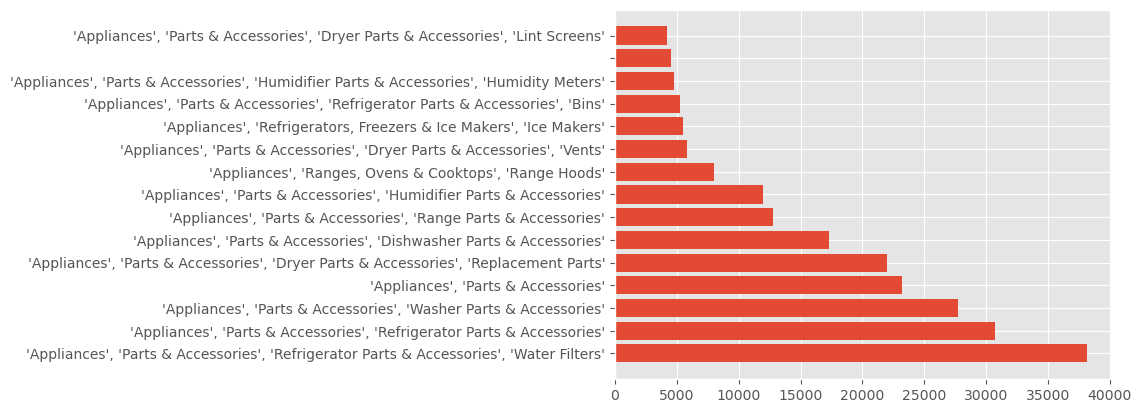

In [14]:
joined = pd.merge(df, meta_df, left_on='asin', right_on='asin')

# List to string
categories = joined['category'].value_counts(ascending=False)
top_categories = categories[:15]

# Display
fig, ax = plt.subplots()
plt.barh(width=list(top_categories), y=list(top_categories.index))
plt.show()

In [15]:
# For the selected meta data
meta_product_df = meta_df[meta_df['category'].isin(list(top_categories.index))]\
    .reset_index(drop=True)
meta_product_df.to_parquet(os.path.join(out_dir, 'meta_product_df.parquet'))

# For the selected products
product_df = df[df['asin'].isin(meta_product_df['asin'].unique())]\
    .reset_index(drop=True)
product_df

# Testing import
#import_test = pd.read_parquet(os.path.join(out_dir, 'meta_product_df.parquet'))
#import_test

,asin,overall,text,summary,date,style,vote
0,B00004SQHD,5.0,I like the fact that the wire ends have mounti...,complete package,2013-04-20,"{'Size:': ' 6 ft', 'Style:': ' (Old)'}",NaN
1,B00004SQHD,5.0,"Needed another couple of feet with new dryer, ...",Perfect Fit,2013-03-16,"{'Size:': ' 6 ft', 'Style:': ' (Old)'}",2
2,B00004SQHD,5.0,Good quality at a reasonable price,Everything works,2017-02-14,"{'Size:': ' 4-Foot', 'Style:': ' (Old)'}",NaN
3,B00004SQHD,5.0,Planning on hooking this to my RV,50 amp cable,2016-12-21,"{'Size:': ' 4-Foot', 'Style:': ' (Old)'}",NaN
4,B00004SQHD,5.0,This product is a pretty simple one. I do lik...,"Good range cord, standard nema 14-50p fits wit...",2016-04-15,"{'Size:': ' 6 ft', 'Style:': ' (Old)'}",NaN
...,...,...,...,...,...,...,...
219890,B01HIQV5DE,5.0,Seems like it works as it is supposed to. We h...,Seems like it works as it is supposed to,2017-12-24,<NA>,NaN
219891,B01HIQV5DE,5.0,"Delivered on time, working fine, thanks!",Refrigerator water filters,2017-10-26,<NA>,NaN
219892,B01HIQV5DE,5.0,Order came quickly and works wonderfully in ou...,Order came quickly and works wonderfully in ou...,2017-10-09,<NA>,NaN
219893,B01HIQV5DE,3.0,"really wanted to love this! I truly did, I pur...",really wanted to love this! I truly did,2017-09-20,<NA>,NaN


## Text Analytics
Examples:
* Relashionships between features 
* Word frequency analysis,
* Sentence length analysis,
* Average word length analysis

In [16]:
# Readability

#df['text_standard']=df['text'].apply(lambda x: textstat.text_standard(x))
# df['dale_chall_score']=df['text'].apply(lambda x: textstat.dale_chall_readability_score(x))
# df['flesh_reading_ease']=df['text'].apply(lambda x: textstat.flesch_reading_ease(x))
df['gunning_fog']=df['text'].apply(lambda x: textstat.gunning_fog(x))
df['reading_time']=df['text'].apply(lambda x: textstat.reading_time(x))

# Define the function to count words
def count_words(string):
    words = string.split()
    return len(words)

# Count words
df['text_len'] = df['text'].apply(count_words)

# Count letters
#product_df['text_len'] = product_df['text'].str.len()

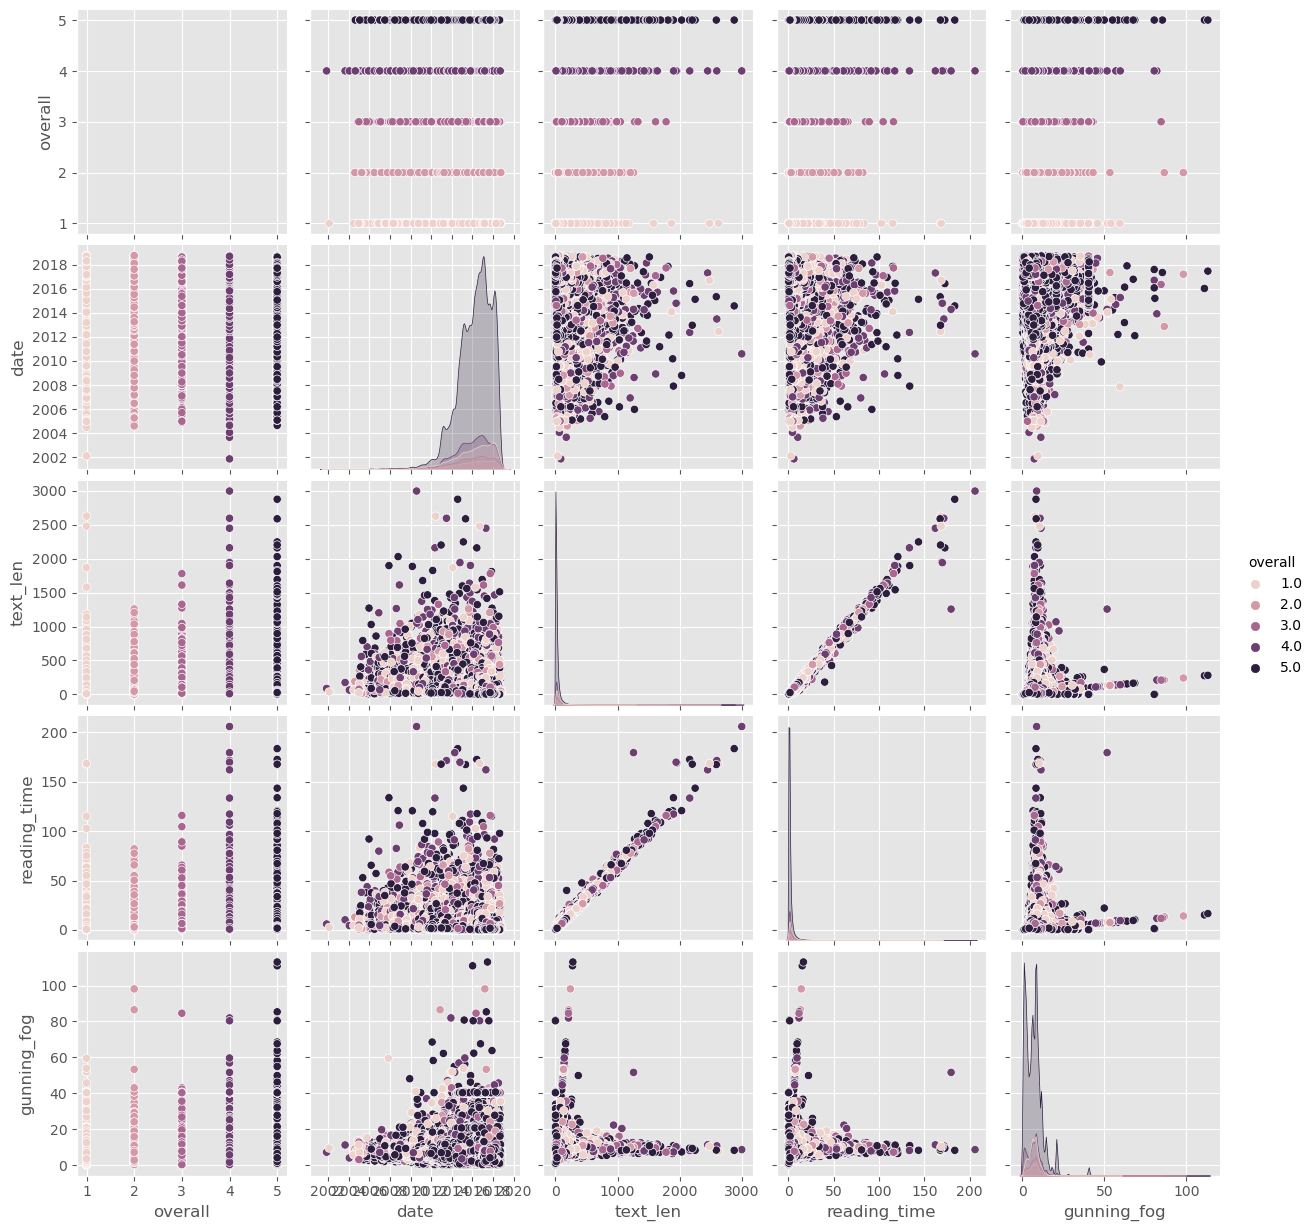

In [17]:
# To make the pairplot to check how is the data
df = df.astype({'overall': 'float16'}, errors='ignore')

sns.pairplot(df,
             vars=['overall', 'date', 
             'text_len', 'reading_time', 'gunning_fog'],
            hue='overall'
            )
plt.show()

# The dataset is skewed towards positive reviews (score > 3)